In [1]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torchaudio

import numpy as np
import pandas as pd
import librosa
import PIL
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import display, Markdown

In [2]:
import shared.utils as su

Failed to import torchvideotransforms. Proceeding without.
Please install using:
pip install git+https://github.com/hassony2/torch_videovision


In [3]:
sys.path.append(os.path.join(su.log.repo_path, "train"))
from network.autoencoder.autoencoder import AutoEncoder

### Load original samples

In [4]:
data_root = su.paths.get_data_root_from_hostname()
data_dir = os.path.join(
    data_root, "PouringLiquidsData",
)
meta_dir = os.path.join(os.path.dirname(su.log.repo_path), "PouringLiquidsData")

video_clip_dir = os.path.join(data_dir, "resized_clips")
audio_clip_dir = os.path.join(data_dir, "resized_clips_wav")
# First frame of the video to get a sense of the container
frame_dir = os.path.join(data_dir, "first_frames")
annot_dir = os.path.join(meta_dir, "annotations")

# Load side information: containers
container_path = os.path.join(
    meta_dir, "annotations/containers.yaml",
)
assert os.path.exists(container_path)
containers = su.io.load_yml(container_path)

# Load CSV
csv_path = os.path.join(annot_dir, f"localisation.csv")
df = pd.read_csv(csv_path)
print(" [:::] Shape of CSV (in original form): ", df.shape)

# Update CSV with container information (optional)
update_with_container_info = True
if update_with_container_info:
    rows = []
    for row in df.iterrows():
        row = row[1].to_dict()
        row.update(containers[row["container_id"]])
        rows.append(row)
    df = pd.DataFrame(rows)

# Update item_id
df["item_id"] = df.apply(
    lambda d: f"{d['video_id']}_{d['start_time']:.1f}_{d['end_time']:.1f}",
    axis=1,
)
# Update video clip path
df["video_clip_path"] = df["item_id"].apply(
    lambda d: os.path.join(
        video_clip_dir, f"{d}.mp4"
    )
)
df = df[df["video_clip_path"].apply(os.path.exists)]
print(" [:::] Shape of CSV with available video: ", df.shape)
# Update audio clip path
df["audio_clip_path"] = df["item_id"].apply(
    lambda d: os.path.join(
        audio_clip_dir, f"{d}.wav"
    )
)
df = df[df["audio_clip_path"].apply(os.path.exists)]
print(" [:::] Shape of CSV with available audio: ", df.shape)

# Update first frame path
df["first_frame_path"] = df["video_id"].apply(
    lambda d: os.path.join(
        frame_dir, f"{d}.png"
    )
)
df = df[df["first_frame_path"].apply(os.path.exists)]
print(" [:::] Shape of CSV with available frames: ", df.shape)

df.shape

 [:::] Shape of CSV (in original form):  (100, 9)
 [:::] Shape of CSV with available video:  (100, 16)
 [:::] Shape of CSV with available audio:  (100, 17)
 [:::] Shape of CSV with available frames:  (100, 18)


(100, 18)

In [5]:
# Filter only cylindrical containers
df = df[df["shape"].isin(["cylindrical"])]
print(" [:::] Shape of CSV with only cylindrical containers: ", df.shape)
df.shape

 [:::] Shape of CSV with only cylindrical containers:  (50, 18)


(50, 18)

### Load Autoencoder model

In [6]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load config
config = os.path.join(su.log.repo_path, "configs/pld_80.yaml")
config = OmegaConf.load(config)

# Load model
net = AutoEncoder(config)

# Load trained checkpoint
ckpt_dir = "/work/piyush/experiments/ddsp-pytorch/pld_80/checkpoints"
ckpt_id = "200131.pth-100000"
ckpt_path = os.path.join(ckpt_dir, ckpt_id)
assert os.path.exists(ckpt_path), f"Checkpoints does not exist at {ckpt_path}"
print(" [:::] Checkpoint path: ", ckpt_path)
msg = net.load_state_dict(torch.load(ckpt_path))
print(" [:::] Loaded checkpoint: ", msg)

# Important: set in eval mode
net.eval()

# Move to device
net = net.to(device)

su.misc.num_params(net)

 [:::] Checkpoint path:  /work/piyush/experiments/ddsp-pytorch/pld_80/checkpoints/200131.pth-100000
 [:::] Loaded checkpoint:  <All keys matched successfully>
 [:::] Number of total parameters in AutoEncoder: 4.346M


### Generate

In [7]:
sr = 16000
stft = dict(n_fft=512, hop_length=256, n_mels=64)
margin = 8.

In [8]:
# Load original audio to compute loudness
def load_audio(audio_path, sample_rate):

    # Load
    y, true_sample_rate = torchaudio.load(audio_path)

    # Resample if sampling rate is not equal to model's
    if true_sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(true_sample_rate, sample_rate)
        y = resampler(y)

    return y

In [9]:
def waveform_to_logmelspec(y, sr, n_fft, hop_length, n_mels, fmin=0, fmax=sr//2):
    """Converts a waveform (torch.Tensor) to log-mel-spectrogram."""

    if len(y.shape) == 2:
        y = y.squeeze(0)
    y = y.cpu().numpy()
    
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax, fmin=fmin
    )
    S = librosa.power_to_db(S, ref=np.max)

    return S

In [10]:
i = np.random.choice(len(df))
print("Index: ", i)
row = df.iloc[i].to_dict()

audio_path = row["audio_clip_path"]

# Load audio
y = load_audio(audio_path, config.sample_rate)

# Get logmelspectrogram
S = waveform_to_logmelspec(y=y, sr=sr, **stft)

# Get first frame (to show container)
first_frame = PIL.Image.open(row["first_frame_path"])

# Get measurements & duration
measurements = row["measurements"]
h_true = measurements["net_height"]
r_true = 0.25 * (measurements["diameter_bottom"] + measurements["diameter_top"])
duration_true = row["end_time"] - row["start_time"]

y.shape, S.shape, first_frame.size, r_true, h_true, duration_true

Index:  47


(torch.Size([1, 131755]), (64, 515), (270, 480), 3.5, 9.0, 8.23292)

In [11]:
def show_true_example(first_frame, S, r_true=None, h_true=None, duration_true=None, figsize=(11, 3.4), title_prefix=""):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(1, 5)
    ax = fig.add_subplot(gs[0])
    ax.imshow(first_frame)
    r = lambda x: np.round(x, 2)
    
    ax = fig.add_subplot(gs[1:])
    img = librosa.display.specshow(
        S, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax,
    )
    # fig.colorbar(img, ax=ax, format='%+2.0f dB')

    title = f"[{title_prefix}]     Radius: {r(r_true)} (cms) | Height: {r(h_true)} (cms) | Duration: {r(duration_true)} (s)"
    plt.suptitle(title, y=0.95)

    plt.tight_layout()
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.show()

# show_true_example(first_frame, S, r_true, h_true, duration_true)

In [12]:
# Get loudness from a real audio
with torch.no_grad():
    loudness = net.encoder.loudness_extractor({"audio": y.to(device)})

num_frames = loudness.shape[1]

loudness.shape

torch.Size([1, 2058])

In [13]:
# Define constants
c = 340 * 100 # cms/sec
beta = 0.62 # 1/sec
F_max = (sr // 2) / 2.
F_min = 0
radius_range = [1., 5.] # cm
height_range = [5., 20.] # cm
duration_range = [5., 15.] # sec


# Define the frequency bins (typically, 257 bins)
frequencies = librosa.fft_frequencies(
    sr=sr, n_fft=stft["n_fft"],
)
num_freqs = len(frequencies)


# Define functions
def compute_length_of_air_column(T, duration, height, b=0.01):
    """
    Randomly chooses a l(t) curve satisfying the two point equations.
    By default approximates a linear curve.
    """
    if b is None:
        # Choose randomly
        b = np.random.uniform(-1, 1.)
        # Ensure that b is non-zero
        if b == 0:
            b = 0.1
    else:
        # Use b as is given
        pass
    L = height * ( (1 - np.exp(b * (duration - T))) / (1 - np.exp(b * duration)) )
    return L, b


def compute_fundamental_frequencies(duration, height, radius, b=0.01, num_evals=100):
    """Computes the F0 given duration and container parameters."""

    global sr, stft

    # Sample timestamps T
    num_frames = librosa.time_to_frames(
        [duration],
        sr=sr,
        hop_length=stft["hop_length"],
        n_fft=stft["n_fft"],
    )[0]
    T = np.linspace(0, duration, num_evals)

    # Compute length of air column
    L, b = compute_length_of_air_column(T, duration, height, b)
    
    # Compute fundamental frequency curve
    F0 = (0.25 * c) * (1. / (L + (beta * radius)))

    return T, L, F0, b


def compute_dynamics(measurements, duration, num_evals=100):
    """Computes theoretical estimate of l(t) and f(t) for a cylinder."""

    h = measurements["net_height"]
    r_bot = measurements["diameter_bottom"] / 2.
    r_top = measurements["diameter_top"] / 2.
    r = (r_bot + r_top) / 2.

    # Create a physics vector
    b = 0.01
    physical_params = np.array([h, r, duration, b])

    T, L, F0, b = compute_fundamental_frequencies(duration, h, r, b=b, num_evals=num_evals)

    return T, L, F0, duration, physical_params


def show_latents(T, L, F0, physical_params):
    """Plots the latent parameters like length of air column and frequency."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 3))
    ax = axes[0]
    ax.grid(alpha=0.4)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Length of air columns (cms)")
    ax.plot(T, L, "--", color="blue", linewidth=2.)
    ax.set_xlim(0, T[-1])
    ax = axes[1]
    ax.grid(alpha=0.4)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.plot(T, F0, "--", color="orange", linewidth=2.)
    ax.set_xlim(0, T[-1])

    height, radius, duration, b = physical_params
    r = lambda x: np.round(x, 3)
    title = "$\\Theta = \{ R = %s, \  H = %s, \ D = %s, \ b=%s \}$" % (r(radius), r(height), r(duration), r(b))
    plt.suptitle(title, y=0.99, fontsize=17)
    plt.tight_layout()
    plt.show()

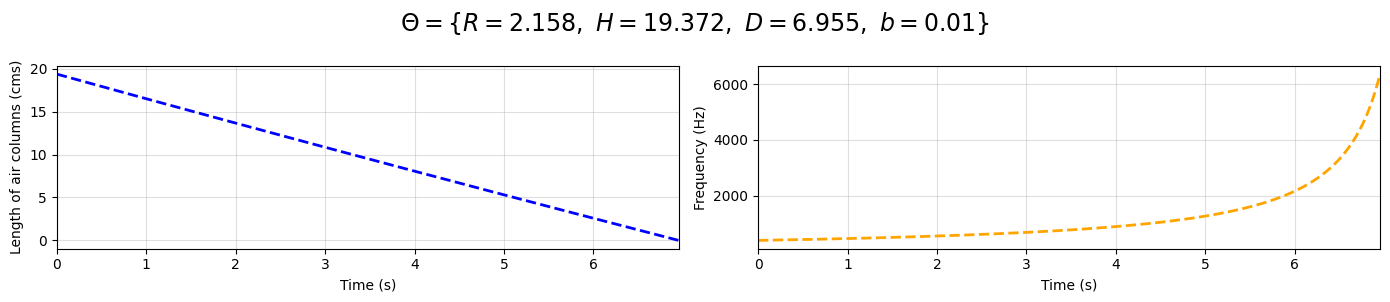

In [14]:
# Select a container with random measurements
radius_ = np.random.uniform(*radius_range)
height_ = np.random.uniform(*height_range)
duration_ = np.random.uniform(*duration_range)

# Define measurements of the synthetic container
measurements_ = dict(
    diameter_top=2 * radius_,
    diameter_bottom=2 * radius_,
    net_height=height_,
)

# Compute dynamics of pouring water in this container
T, L, F0, duration, physical_params = compute_dynamics(
    measurements_, duration_, num_evals=num_frames,
)

# Plot the latents (of the dynamic system)
show_latents(T, L, F0, physical_params)

In [15]:
# Generate synthetic audio

batch = {"f0": torch.from_numpy(F0).to(loudness.device).float().unsqueeze(0), "loudness": loudness}
latent = net.decoder(batch)
harmonic = net.harmonic_oscillator(latent)
noise = net.filtered_noise(latent)
audio_synth = harmonic + noise[:, : harmonic.shape[-1]]

# Increase volume
audio_synth = audio_synth * 1
audio = dict(
    harmonic=harmonic, noise=noise, audio_synth=audio_synth,
)
audio["audio_reverb"] = net.reverb(audio)
audio["a"] = latent["a"]
audio["c"] = latent["c"]
# dereverb = audio["audio_synth"].cpu()

y_generated_dereverb = audio["audio_synth"].cpu()
y_generated_reverb = audio["audio_reverb"].cpu()

y.shape, y_generated_reverb.shape, y_generated_dereverb.shape

(torch.Size([1, 131755]), torch.Size([1, 179711]), torch.Size([1, 131712]))

Showing original example :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::  


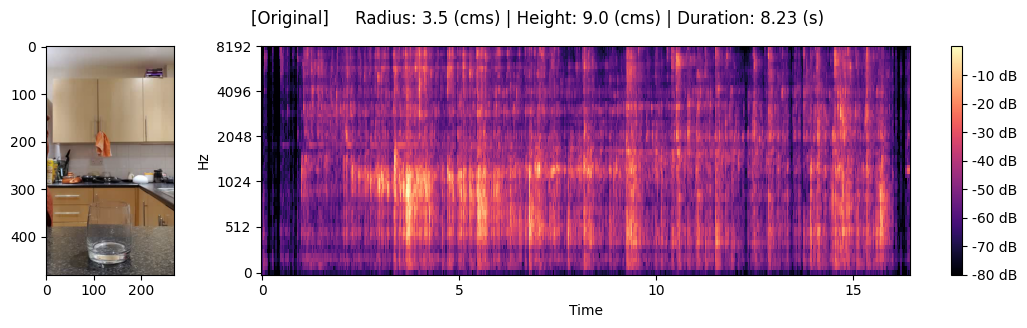

---

Showing generated example ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::  


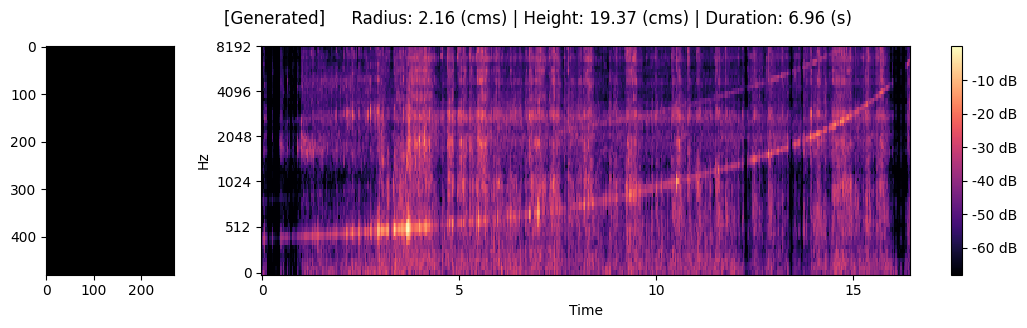

In [16]:
# Show original example
su.log.print_update("Showing original example ", pos="left", color="blue")

show_true_example(first_frame, S, r_true, h_true, duration_true, title_prefix="Original")
su.visualize.show_single_audio(data=y.cpu().numpy()[0], rate=sr)

display(Markdown('---'))


# Show generated example
su.log.print_update("Showing generated example ", pos="left", color="blue")
empty_image = PIL.Image.new('RGB', first_frame.size)

y_gen = y_generated_dereverb
S_gen = waveform_to_logmelspec(y=y_gen.detach(), sr=sr, **stft)
show_true_example(empty_image, S_gen, radius_, height_, duration_, title_prefix="Generated")
su.visualize.show_single_audio(data=y_gen.detach().cpu().numpy()[0], rate=sr)


## Old code

In [ ]:
y_generated_dereverb = audio["audio_synth"].cpu()
output_id = "sample_synthetic_dereverb"
torchaudio.save(
    os.path.splitext(output_id)[0] + "_synth.wav", y_generated_dereverb, sample_rate=config.sample_rate
)

y_generated_reverb = audio["audio_reverb"].cpu()
output_id = "sample_synthetic_reverb"
torchaudio.save(
    os.path.splitext(output_id)[0] + "_synth.wav", y_generated_reverb, sample_rate=config.sample_rate
)

In [ ]:
import gradio as gr

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
)

demo.launch(server_name="localhost", inline=True, share=True)
